# Beam Shape Analysis - Tapered Fibre, Full Radial Analysis

### What does this notebook do?

Experimental analysis
- Import Gaussian beamshape data and z values through pandas to np arrays
- Translate and transform Gaussians to reduce fitting parameters 
- Fit the beamshape Gaussians to a one parameter fit to find their waists, w
- Plot ws vs zsin(theta) and fit to (Two/ three parameter?) Fit
- Key: what is z0 and w0 experimentally for the fibre?

Theoretical Analysis
- Takes in wavelength, NA, core radius to calculate V number
- Use marcuse relation to find minumum waist
- Comparison?

## Import all useful libraries / tools

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.optimize import curve_fit
from os import listdir
import scipy

from lvl4_functions import *

## Import Data

In [2]:
# Define useful path to data
globalpath = "C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/Memory Stick Backup/Confocal Work/2024-02-14/Data-Set2/"

In [3]:
# Import data
distances, amplitudes = import_data(globalpath)

['DL_02.csv', 'DL_03.csv', 'DL_04.csv', 'DL_05.csv', 'DL_06.csv', 'DL_07.csv', 'DL_08.csv', 'DL_09.csv', 'DL_10.csv', 'DL_12.csv', 'DL_13.csv', 'DL_14.csv', 'DL_15.csv', 'DL_16.csv', 'DL_17.csv', 'DL_18.csv', 'DL_19.csv', 'DL_20.csv', 'DL_21.csv', 'DL_22.csv', 'DL_23.csv', 'DL_24.csv', 'DL_25.csv', 'DR_02.csv', 'DR_03.csv', 'DR_04.csv', 'DR_05.csv', 'DR_06.csv', 'DR_07.csv', 'DR_08.csv', 'DR_09.csv', 'DR_10.csv', 'DR_12.csv', 'DR_13.csv', 'DR_14.csv', 'DR_15.csv', 'DR_16.csv', 'DR_17.csv', 'DR_18.csv', 'DR_19.csv', 'DR_20.csv', 'DR_21.csv', 'DR_22.csv', 'DR_23.csv', 'DR_24.csv', 'DR_25.csv', 'H_02.csv', 'H_03.csv', 'H_04.csv', 'H_05.csv', 'H_06.csv', 'H_07.csv', 'H_08.csv', 'H_09.csv', 'H_10.csv', 'H_12.csv', 'H_13.csv', 'H_14.csv', 'H_15.csv', 'H_16.csv', 'H_17.csv', 'H_18.csv', 'H_19.csv', 'H_20.csv', 'H_21.csv', 'H_22.csv', 'H_23.csv', 'H_24.csv', 'H_25.csv', 'V_02.csv', 'V_03.csv', 'V_04.csv', 'V_05.csv', 'V_06.csv', 'V_07.csv', 'V_08.csv', 'V_09.csv', 'V_10.csv', 'V_12.csv', 'V_13

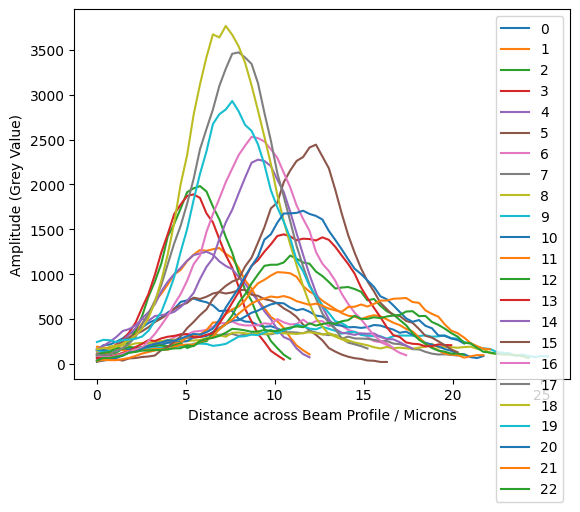

In [4]:
# Define how many data points we have. 'data size'
ds = 23

# Quick plot of raw data
for i in range(ds):
    plt.plot(distances[i+ds], amplitudes[i+ds], label = '{}'.format(i))

plt.legend()

plt.xlabel('Distance across Beam Profile / Microns')
plt.ylabel('Amplitude (Grey Value)')

plt.show()

## Normalise, cut down data

In [5]:
all_distances, all_amps = data_trim(distances, amplitudes, 10000000)

## Errors - for above normalised Gaussians

In [6]:
''' Error on cross sectional distance'''
# Scale says ~4.3055 pixels / microns therefore 0.232 microns / pixel
# so lets set error as 0.2 microns

all_distances_errors = []

for i in range(len(all_distances)):
    all_distances_errors.append(np.ones(np.size(all_distances[i]))*0.2) # takes into account different sized data sets

''' Error on amplitude '''
# Grey value resolution = 1
# But 12 bit image = 2^12 = 4096 available 'colours'
# Say 10% accuracy

all_amps_errors = []

for i in range(len(all_amps)):
    err = 40.96 / np.max(amplitudes[i])
    all_amps_errors.append(np.ones(np.size(all_amps[i]))*err) # takes into account different sized data sets

Plot Normalised Gaussian Curves with Errors

In [7]:
# Plot of a far field 'Gaussian' - is this a TEM10 mode?
# plt.errorbar(all_distances[-1], all_amps[-1], xerr=all_distances_errors[-1],yerr=all_amps_errors[-1])

## Fit Data

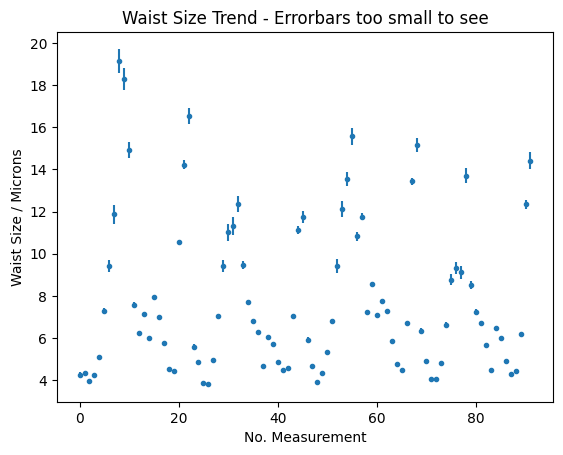

In [8]:
# Create some empty arrays to store values of interest
params_ = np.zeros((len(all_distances),3))
y_fits = [] # NB: this has to be a list due to different sized arrays sitting in it
params_errs_ = np.zeros((len(all_distances),3))
chi_red_array = np.zeros(len(all_distances))

# Populate initial guess array - important to change per data set!!
initial_guesses = np.zeros((len(all_distances),3))
initial_guesses[:,0] = 3
initial_guesses[:,1] = 6
initial_guesses[:,2] = 1
initial_guesses[1,1] = 10
initial_guesses[17,1] = 10
initial_guesses[18,1] = 10
initial_guesses[9,0] = 20
initial_guesses[38,0] = 20
initial_guesses[43,0] = 20
initial_guesses[45,0] = 20
initial_guesses[58,0] = 20
initial_guesses[68,0] = 20
# initial_guesses[14:,1] = 50
# initial_guesses[0,0] = 0.2

for i in range(len(all_distances)):
    singlefit, params_[i], params_errs_[i], chi_red_array[i] = fit_labs(all_distances[i],all_amps[i], all_amps_errors[i], Gauss, initial_guesses[i])
    y_fits.append(singlefit)

waists = params_[:,0]
waists_errs = params_errs_[:,0]
# print(waists)
# print(len(waists))
# print(waists_errs)

# Plot waist trend 
plt.errorbar(np.arange(len(all_distances)),waists, yerr = waists_errs, linestyle = '', marker = 'o', ms = 3)
plt.xlabel('No. Measurement')
plt.ylabel('Waist Size / Microns')
plt.title('Waist Size Trend - Errorbars too small to see')

for i in range(len(waists)):
    if waists[i] < 0:
        print(i, waists[i])

[ 15.15446333  12.93661677 170.90513409]


Text(0, 0.5, 'Normalised Amplitude')

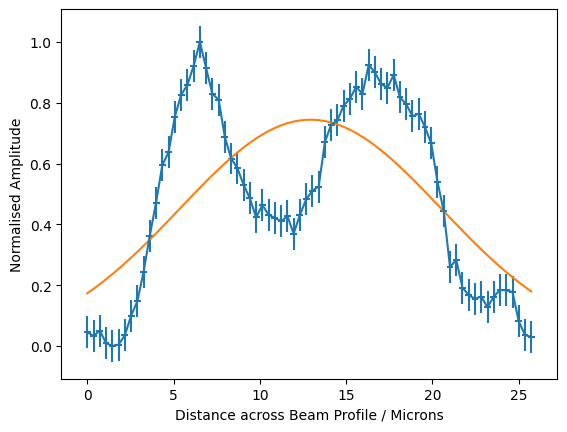

In [9]:
t = 68
plt.errorbar(all_distances[t], all_amps[t], xerr=all_distances_errors[t],yerr=all_amps_errors[t])
plt.plot(all_distances[t],y_fits[t])
print(params_[t])

plt.xlabel('Distance across Beam Profile / Microns')
plt.ylabel('Normalised Amplitude')

In [10]:
''' Split waist fits into vertical and horizontal measurements and take average'''

dl_waists = waists[0:ds]
dr_waists = waists[ds:2*ds]
h_waists = waists[2*ds:3*ds]
v_waists = waists[3*ds:]

dl_waists_errs = waists_errs[0:ds]
dr_waists_errs = waists_errs[ds:2*ds]
h_waists_errs = waists_errs[2*ds:3*ds]
v_waists_errs = waists_errs[3*ds:]

waists_array = np.array([dl_waists, dr_waists, h_waists,v_waists]) 
mean_waists = np.mean(waists_array, axis = 0)
std_waists = np.std(np.array(waists_array), axis = 0) / np.sqrt(np.shape(waists_array)[0])
print(mean_waists, std_waists)

[ 5.52014382  4.70091986  3.94648191  4.11418402  5.06389434  6.93064256
  9.25576424 11.08184046 13.27566003 14.98920116 10.93751209  8.57343902
  6.74750318  6.91776698  5.57036128  7.06260125  6.49333488  5.3534066
  4.51265948  4.50055419  7.61626276 12.78190567 14.4632392 ] [0.38654197 0.11042587 0.03998542 0.10091277 0.09658719 0.12205064
 0.13936621 0.5444302  1.86761029 1.11264199 1.21702442 0.9254928
 0.17146943 0.54229403 0.5227975  0.40796399 0.32859512 0.23213999
 0.08415043 0.02540725 0.86325028 0.5852717  0.87164226]


## Calculating Z values and Plotting Waist size against Z

In [11]:
# Define Global Path for where 'z' values are stored
z_path = 'C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/Memory Stick Backup/Confocal Work/2024-02-14/Data-Set2/zs.csv'

# Import as dataframe
df_lengths = pd.read_csv(z_path)

# Convert to array. Called 'lengths' as this isnt the z values yet
lengths = np.array(df_lengths['zs'])

# Take error as confocal z stack resolution ie 0.1
lengths_errs = np.ones(len(lengths))*0.1

In [12]:
print(lengths)

[-15.6 -11.7  -7.8  -3.9   0.    3.9   7.8  11.7  15.6  23.4  27.3  31.2
  35.1  39.   42.9  46.8  50.7  54.6  58.5  62.4  66.3  70.2  74.1]


This 'lengths' value MIGHT need to be multiplied by cos theta? Where theta is angle of elevation of the fibre... but won't do this yet.

## Fit Waists vs Z

In [13]:
# Need wavelength of light to calc. Rayleigh Range (in microns)
wavelength = 0.635
wavelength_err = 0.005 # according to online spec (THORLABS CPS405)

Angle of elevation

<ErrorbarContainer object of 3 artists>

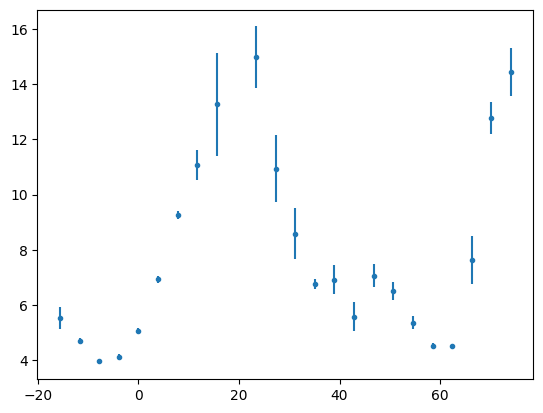

In [14]:
# online protractor at https://www.ginifab.com/feeds/angle_measurement/ 
# NB: see image 'C:\Users\abiga\OneDrive - Durham University\1. Fourth Year\1. Project\1. Data Analysis\Christmas Report\Cleaved-2\Cleaved - fibre- pics\cleaved_elev_angle'

# A plot of waists vs z
plt.errorbar(lengths, mean_waists, yerr = std_waists, linestyle = '', marker = 'o', ms = 3)


Got two intensity peaks - so need two fits

In [25]:
# split data sets and errors
lengths1 = lengths[0:9]
lengths_errs1 = lengths_errs[0:9]
mean_waists1 = mean_waists[0:9]
std_waists1 = std_waists[0:9]

lengths2 = lengths[9:]
lengths_errs2 = lengths_errs[9:]
mean_waists2 = mean_waists[9:]
std_waists2 = std_waists[9:]
print(mean_waists2)

waist_fit1, params1, params_errs1, chisqu_WvsZ1 = fit_labs(lengths1, mean_waists1, std_waists1, WvsZ, np.array([5,1,2]))
w01, z01,RR1= params1
w0_err1, z0_err1,RR_err1 = params_errs1

waist_fit2, params2, params_errs2, chisqu_WvsZ2 = fit_labs(lengths2, mean_waists2, std_waists2, WvsZ, np.array([5,1,2]))
w02, z02,RR2= params2
w0_err2, z0_err2,RR_err2 = params_errs2

[14.98920116 10.93751209  8.57343902  6.74750318  6.91776698  5.57036128
  7.06260125  6.49333488  5.3534066   4.51265948  4.50055419  7.61626276
 12.78190567 14.4632392 ]


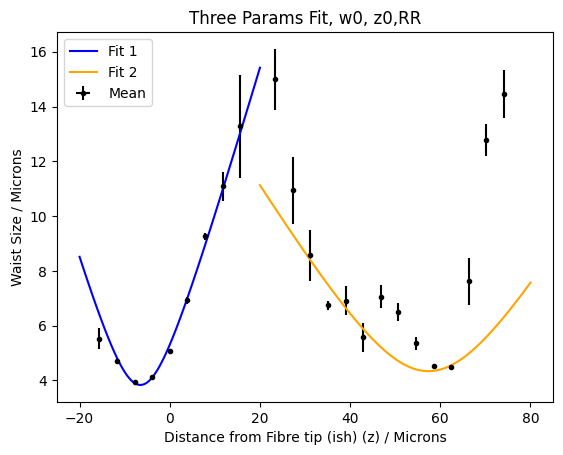

In [30]:
# Plot waists vs Z:
plt.errorbar(lengths, mean_waists, xerr = lengths_errs, yerr = std_waists, linestyle = '', marker = 'o', ms = 3, color = 'k',label = 'Mean')
plt.plot(np.linspace(-20,20,100), WvsZ(np.linspace(-20,20,100), w01, z01,RR1), color = 'blue', label = 'Fit 1')
plt.plot(np.linspace(20,80,100), WvsZ(np.linspace(20,80,100), w02, z02,RR2), color = 'orange', label = 'Fit 2')

# plt.errorbar(lengths, h_waists, yerr = h_waists_errs, linestyle = '', marker = 'o', ms = 3, label = 'Horizontal')
# plt.errorbar(lengths, dl_waists, yerr = dl_waists_errs, linestyle = '', marker = 'o', ms = 3, label = 'L Diagonal')
# plt.errorbar(lengths, dr_waists, yerr = dr_waists_errs, linestyle = '', marker = 'o', ms = 3, label = 'R Diagonal')
# plt.errorbar(lengths, v_waists, yerr = v_waists_errs, linestyle = '', marker = 'o', ms = 3, label = 'Vertical')

plt.xlabel('Distance from Fibre tip (ish) (z) / Microns')
plt.ylabel('Waist Size / Microns')
plt.title('Three Params Fit, w0, z0,RR')
plt.legend()

In [32]:
print('The minimum waist is {} pm {}'.format(w01, w0_err1))
print('The distance from the smallest z measurement to the minimum waist is {} pm {}'.format(z01, z0_err1))
#print('The weird systematic error Y is {} pm {}'.format(Y0, Y0_err))
print('The Rayleigh Range is {} pm {}.'.format(RR1,RR_err1))
print('The reduced chi squared value of this fit is {}'.format(chisqu_WvsZ1))

print('    ')

print('The minimum waist is {} pm {}'.format(w02, w0_err2))
print('The distance from the smallest z measurement to the minimum waist is {} pm {}'.format(z02, z0_err2))
#print('The weird systematic error Y is {} pm {}'.format(Y0, Y0_err))
print('The Rayleigh Range is {} pm {}.'.format(RR2,RR_err2))
print('The reduced chi squared value of this fit is {}'.format(chisqu_WvsZ2))

The minimum waist is 3.8370214654304466 pm 0.041052030938750886
The distance from the smallest z measurement to the minimum waist is -6.506529453990029 pm 0.17741659651539907
The Rayleigh Range is 6.81200579991943 pm 0.18932263479790576.
The reduced chi squared value of this fit is 3.3094835736941253
    
The minimum waist is 4.340218448460577 pm 0.07297821727434739
The distance from the smallest z measurement to the minimum waist is 57.375055977063965 pm 0.6848527060371995
The Rayleigh Range is 15.826153303087036 pm 0.9613059947740291.
The reduced chi squared value of this fit is 32.87784835442111


In [29]:
print('The wavelength check in nanometres is {} nm'.format(wavelength_check(w01,RR1)))
print('This is approx. {}x the actual wavelength'.format( wavelength_check(w01,RR1) / (wavelength*10**3)))

The wavelength check in nanometres is 6789.8991095183765 nm
This is approx. 10.692754503178545x the actual wavelength


## Now Move Graph so waist min is at z = 0

In [18]:
# horizontal axis with min fitted waist set to zero
zs_0 = zs - z0
zs_0_err = np.sqrt(zs_err**2 + z0_err**2)

# z value at which fibre end occurs
z_end = zs_0[0] - 4

z_end_err = np.sqrt(zs_0_err[0]**2 + 1**2) # error on 4 measurement of 1 micron - high!

print('The fibre end is at z value {} pm {}'.format(z_end,z_end_err))
z_end = np.round_(z_end, decimals = 0)
z_end_err = np.round_(z_end_err, decimals = 0)
print('The fibre end is at z value {} pm {}'.format(z_end,z_end_err))

# Residuals 
wz_res = norm_residuals(zs,waists_comp,waists_comp_err,WvsZ,params)

NameError: name 'zs' is not defined

In [ ]:
# Create Figure
fig, ((ax1,ax3),(ax2,ax4)) = plt.subplots(2,2,height_ratios=(6,1), width_ratios=(6,1), figsize = (8,5))

# Font Settings
font1 = mpl.font_manager.FontProperties(family='Times New Roman',
style='normal', size=12)

# Kill dead plots
ax3.axis('off')
# Kill spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

# Plot waists vs Z:
ax1.errorbar(zs_0, waists_comp, xerr = zs_0_err, yerr = waists_comp_err, color = 'k', linestyle = '', marker = 'o', ms = 3, label = 'Data')
ax1.plot(np.linspace(-20,120,100) - z0, WvsZ(np.linspace(-20,120,100), w0, z0,RR), color = 'navy', label = 'Fit')

# Plot vertical fill line of where fibre end is
ax1.fill_betweenx(y=[5,25],x1=[-1,-1] , x2=[1, 1], color = 'k', alpha = 0.6, label = 'Fibre End')

# Residuals
ax2.errorbar(zs_0,wz_res,color = 'k', linestyle = '', marker = 'o', ms = 3)
ax2.errorbar([-8,120], [0,0], color = 'grey', linestyle = 'dotted')

# Histogram
mean, stderr, sorted_res, dist = histogram_plot(wz_res)
ax4.plot(dist, sorted_res, color = 'black')
ax4.hist(sorted_res, density = True, orientation = 'horizontal', color = 'grey', bins = 4)

# Axis labels
ax2.set_xlabel('Distance from Waist Minimum (z) / microns', font = 'Times New Roman', fontsize = 16)
ax1.set_ylabel('Waist Size / Microns', font = 'Times New Roman', fontsize = 16)
ax1.legend(prop = font1, loc = 'lower right')
ax4.set_xlabel('Freq. Density      ', font = 'Times New Roman', fontsize = 12)

ax1.set_xlim(-10,120)
ax2.set_xlim(-10,120)

#Get Rid of Ticks
ax4.set_xticks(ticks = [], labels = [], fontfamily = 'Times New Roman', fontsize = 10)

# Make visible ticks times new roman
ax1.set_xticks(ticks = np.arange(0,130,20), labels = np.arange(0,130,20), fontfamily = 'Times New Roman', fontsize = 11)
ax2.set_xticks(ticks = np.arange(0,130,20), labels = np.arange(0,130,20), fontfamily = 'Times New Roman', fontsize = 11)

ax1.set_yticks(ticks = np.arange(5,26,2.5), labels = np.round_(np.arange(5,26,2.5), decimals = 1), fontfamily = 'Times New Roman', fontsize = 11)
ax2.set_yticks(ticks = np.arange(-5,6,5), labels = np.round_(np.arange(-5,6,5), decimals = 1), fontfamily = 'Times New Roman', fontsize = 11)
ax4.set_yticks(ticks = np.arange(-5,6,5), labels = np.round_(np.arange(-5,6,5), decimals = 1), fontfamily = 'Times New Roman', fontsize = 11)

In [ ]:
print('The minimum waist is {} pm {}'.format(w0, w0_err))
print('The distance from the first measurement to the minimum waist is {} pm {}'.format(z0, z0_err))
#print('The weird systematic error Y is {} pm {}'.format(Y0, Y0_err))
print('The Rayleigh Range is {} pm {}.'.format(RR,RR_err))
print('The fibre end is at z value {} pm {}'.format(z_end,z_end_err))

In [ ]:
print(chisqu_WvsZ)
print(mean)
print(stderr)

Saving the important info in an array like:
x values
x errs
y values
y errs
residuals 

Second array:
w0, w0err
z0,z0_err
RR, RRerr
z_end, z_end_err

In [ ]:
# np.save('graph_cleaved.npy', np.array([zs_0, zs_0_err, waists_comp, waists_comp_err, wz_res]))
# np.save('params_cleaved.npy', np.array([w0,w0_err,z0, z0_err, RR, RR_err, z_end, z_end_err]))

## Comparison to Experiment - Ray Optics Model

Find k0 and define constants 

In [ ]:
# Defining Parameters of set-up
# info about fibre from 35m cable:
''' https://www.thorlabs.com/drawings/b4627de8c1f781cd-1251149A-D70E-815D-5BD8491D7FDA5B7B/PM1550-HP-SpecSheet.pdf '''

NA = 0.14 # numerical aperture 
NA_err = 0.01

k0 = find_k(wavelength)
k0_err = np.abs(find_k(wavelength+wavelength_err) - k0)
print(k0, k0_err)

a = 9.2e-6 / 2 # core radius, in metres 
a_err = 0.1e-6 / 2 

Find V_no and its error

In [ ]:
V_no = V_number(NA, k0, a)

EC_NA = np.abs(V_number(NA+NA_err, k0, a) - V_no)
EC_k0 = np.abs(V_number(NA, k0+k0_err, a)- V_no)
EC_a = np.abs(V_number(NA, k0, a+a_err) - V_no)

V_no_err = np.sqrt(EC_NA**2 + EC_k0**2 + EC_a**2)

In [ ]:
print('The predicted V no is {} pm {}'.format(V_no, V_no_err))

Using the Marcuse relation to compute theoretical minimum waist from V number and core radius

In [ ]:
w0_theory = marcuse(V_no,a)

# error on w0
cont_V_no = np.abs(marcuse(V_no+V_no_err,a) - w0_theory)
cont_a = np.abs(marcuse(V_no,a+a_err) - w0_theory)

w0_theory_err = np.sqrt(cont_V_no**2 + cont_a**2)

In [ ]:
print('The predicted minimum waist using the ray optics model is {} pm {} microns'.format(w0_theory,w0_theory_err))

## Report Plot - Did the Fibre taper as expected?

In [ ]:
# Import Data from measure function 

measure_data_path = 'C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/1. Data Analysis/Christmas Report/Fibre2-30-11/measure_fn.xlsx'

measure_df = pd.read_excel(measure_data_path)

In [ ]:
# Convert to Array 
diameter = np.array(measure_df['diam_x'])*10**3 # microns
position = np.array(measure_df['position']) - 5

# Theoretical Trend
theo_position = np.arange(-5,5.1,0.1)         
print(diameter) 

# Define Lines

def pos(x):
    return 56.25*x -15.625

def neg(x):
    return -56.25*x -15.625

def const(x):
    return np.ones(x.size)*12.5

neg_bit = np.linspace(-2.5,-0.5,100)
pos_bit = np.linspace(0.5,2.5,100)
const_bit = np.linspace(-0.5,0.5,100)

fig0, ax = plt.subplots(figsize = (10,5))

ax.errorbar(position, diameter, color = 'k', alpha = 0.7, linestyle = '-', marker = 'o', ms = 1, label = 'Measured Diameter')
ax.plot(neg_bit, neg(neg_bit), color = 'blue')
ax.plot(pos_bit, pos(pos_bit), color = 'blue')
ax.plot(const_bit, const(const_bit), color = 'blue')
ax.plot(np.linspace(-5,-2.5,100), np.ones(np.linspace(-5,-2.5,100).size)*125, color = 'blue')
ax.plot(np.linspace(2.5,5,100), np.ones(np.linspace(-5,-2.5,100).size)*125, color = 'blue', label = 'Machine Set Diameter')
ax.legend(prop = mpl.font_manager.FontProperties(family='Times New Roman',
style='normal', size=14))

ax.set_xlabel('Position Along Fibre / mm', font = 'Times New Roman', fontsize = 18)
ax.set_ylabel('Fibre Diameter / microns', font = 'Times New Roman', fontsize = 18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(ticks = np.arange(0,152,25), labels = np.round_(np.arange(0,152,25), decimals = 1), fontfamily = 'Times New Roman', fontsize = 12)
ax.set_xticks(ticks = np.arange(-5,6,2.5), labels = np.arange(-5,6,2.5), fontfamily = 'Times New Roman', fontsize = 12)